In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache
from projects.projectslib.py_utils import range2
import math

def log2ceil(x: int):
    return (x-1).bit_length()

def log2floor(x: int):
    return x.bit_length() - 1

def game(opt=10):
    pot = 2
    while True:
        trial = random.randrange(1, 2**opt)
        pot *= 2 ** (opt - log2ceil(trial)) 
        if trial != 1:
            break
    return pot

def game_unopt():
    pot = 2
    while random.randrange(2) != 0:
        pot *= 2
    return pot

In [3]:
TRIALS = int(1000)
res = [game_unopt() for i in range(TRIALS)]


In [4]:
import numpy as np
cummean = np.cumsum(res) / np.arange(1, len(res) + 1)

In [26]:
import numpy as np
from numpy.polynomial import Polynomial

w = Polynomial.fit(np.log(np.arange(1, TRIALS+1)),cummean , 1)
w

Polynomial([23.39508284,  2.7979425 ], domain=[ 0.        , 16.11809565], window=[-1.,  1.])

&lt;matplotlib.collections.PathCollection at 0x7f87a8e24ad0&gt;

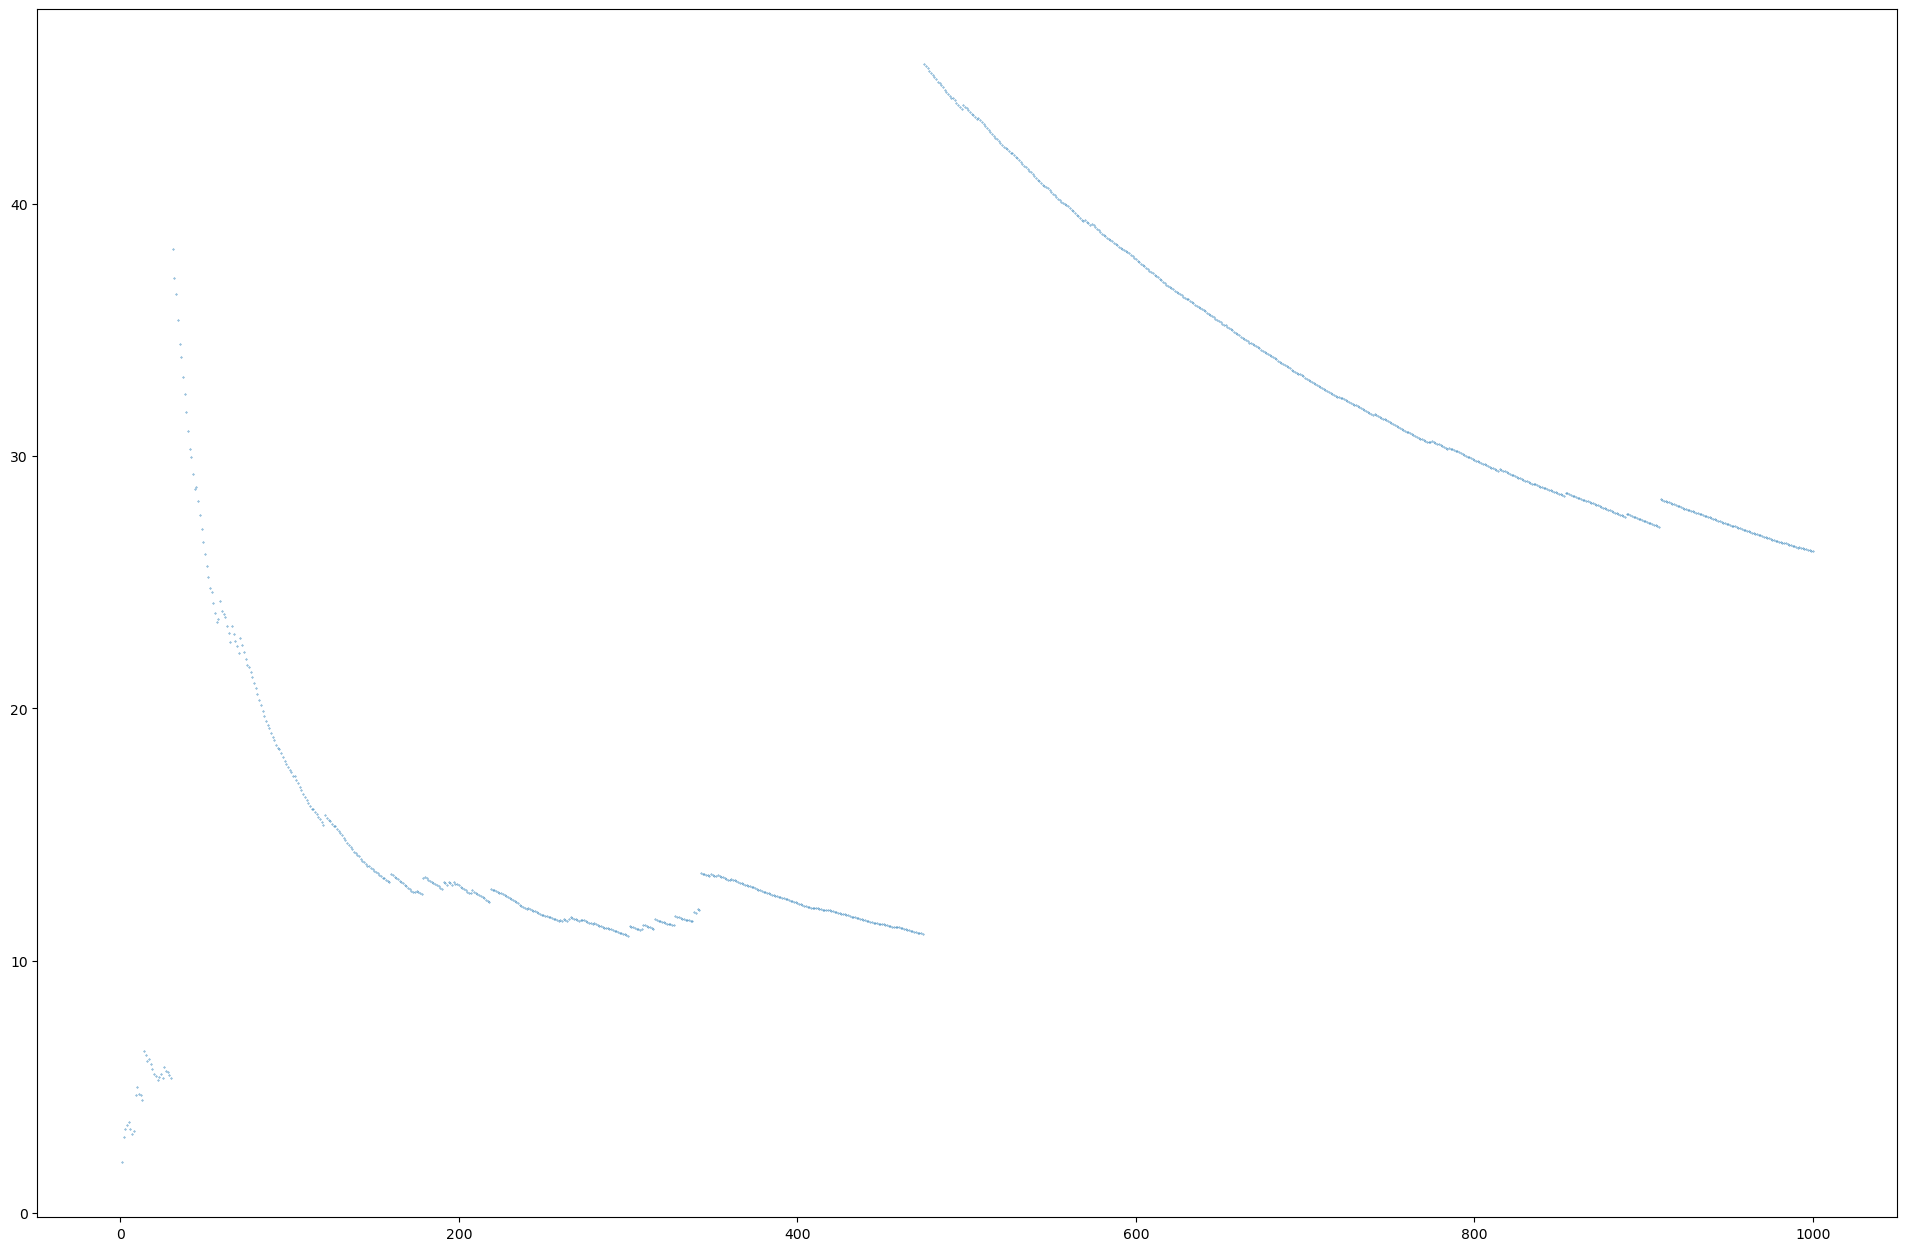

In [8]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(24,16), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(np.arange(1, TRIALS + 1), cummean, s=0.1)
# plt.plot(np.linspace(1.0, TRIALS, num=1000), w.coef[0] + w.coef[1] * np.log(np.linspace(1.0, TRIALS, num=1000)))

In [2]:
from functools import lru_cache
from projects.projectslib.py_utils import range2

@lru_cache(maxsize=None)
def prob(n_games, winnings):
    if winnings <= 2:
        if n_games == 1:
            return 1
        else:
            return 0
    elif n_games == 1:
        return 2 / (2 ** log2ceil(winnings))
    else:
        return sum(prob(n_games - 1, winnings - 2 ** k) / (2 ** k) for k in range(1, log2ceil(winnings)))

def prob_table_build(n_games, winnings):
    table = np.zeros((n_games, winnings))
    # Base case
    table[1-1, 1-1] = 1
    table[1-1, 2-1] = 1
    for w in range2(3, winnings):
        table[1-1, w-1] = 2 / (2 ** log2ceil(w))
    for n in range2(2, n_games):
        for w in range2(2*n - 1, winnings):
            table[n-1, w-1] = sum(table[(n-1)-1, (w-2**k)-1] / (2 ** k) for k in range(1, log2ceil(w)))
    return table

In [3]:
p = prob_table_build(int(3e4), int(6e4))

# print("starting")
# for n in range2(p.shape[0]):
#     for w in range(2 * p.shape[0] - 2):
#         p[n - 1, w - 1] = prob(n, w)
np.savez_compressed("st-petersburg-probs", probabilities=p)

OSError: [Errno 28] No space left on device

In [7]:
np.savez_compressed("st-petersburg-probs", probabilities=p)

In [4]:
p

array([[1.00000000e+00, 1.00000000e+00, 5.00000000e-01, ...,
        3.05175781e-05, 3.05175781e-05, 3.05175781e-05],
       [0.00000000e+00, 0.00000000e+00, 5.00000000e-01, ...,
        3.05175781e-05, 3.05175781e-05, 3.05175781e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.05175784e-05, 3.05175784e-05, 3.05175784e-05],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

The history saving thread hit an unexpected error (OperationalError(&#39;database or disk is full&#39;)).History will not be written to the database.


In [5]:
fig=plt.figure(figsize=(24,16), dpi= 100, facecolor='w', edgecolor='k')

plt.imshow(p.T, cmap='hot')
plt.title("Probability of winning in exactly N games (Mass)")
plt.ylabel("winnings")
plt.xlabel("games played")
plt.show()

fig=plt.figure(figsize=(24,16), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(np.cumsum(p, axis=0).T, cmap='hot')
plt.title("Probability of winning in at most N games (Cumulative Mass)")
plt.ylabel("winnings")
plt.xlabel("games played")
plt.show()

MemoryError: Unable to allocate 13.4 GiB for an array with shape (60000, 30000) and data type float64

(30000, 60000)


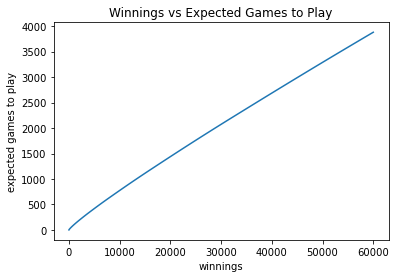

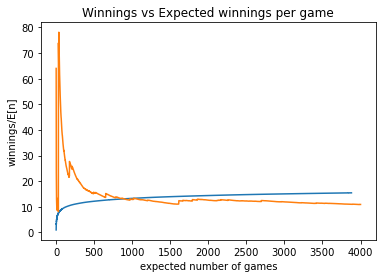

In [25]:
print(p.shape)
en = np.dot(p.T, np.arange(1, p.shape[0]+1))

plt.plot(np.arange(1, len(en) + 1), en)
plt.xlabel("winnings")
plt.ylabel("expected games to play")
plt.title("Winnings vs Expected Games to Play")
plt.show()

plt.plot(en, np.arange(1, len(en) + 1) / en)
plt.plot(np.arange(1, TRIALS+1), cummean)
plt.xlabel("expected number of games")
plt.ylabel("winnings/E[n]")
plt.title("Winnings vs Expected winnings per game")
plt.show()

In [17]:
def dual_sum(f, iter=100):
    res = 0
    a, b = (1, 1)
    cur_diag = a + b
    for i in range(iter):
        while True:
            res += f(a, b)
            if b == 1:
                break
            a, b = (a + 1, b - 1)
        a, b = (1, cur_diag)
        cur_diag = a + b
    return res

def f(k, l):
    return 1 / (2**(k - 1)) + 1 / (2 **(l-1))

dual_sum(f, iter=1500)




5995.999999998526

In [9]:
def with_joint_probs(max_win):
    assert max_win % 2 == 0
    # We'll only use indicies 1...max_win
    cur_joint_probs = np.zeros(max_win + 1)
    past_joint_probs = np.zeros(max_win + 1)
    win_marginal_probs = np.zeros(max_win + 1)
    
    # Compute marginal prob of wins
    # Initialize 1 game probs
    for l in range2(log2floor(max_win)):
        cur_joint_probs[2 ** l] = 1 / (2 ** l)
    yield cur_joint_probs

    # Run recursive step
    for m in range2(2, max_win // 2):
        # Swap cur and past and 0 out cur
        tmp = cur_joint_probs
        cur_joint_probs = past_joint_probs
        past_joint_probs = tmp
        cur_joint_probs[:] = 0

        # Fill in cur_joint_probs
        for w in range2(2 * m, max_win):
            cur_joint_probs[w] = sum(past_joint_probs[(w - 2**k)] / (2 ** k) for k in range2(1, log2ceil(w) - 1))
        yield cur_joint_probs

def calc_expected_games(max_win):
    assert max_win % 2 == 0
    # We'll only use indicies 1...max_win
    win_marginal_probs = np.zeros(max_win + 1)

    winnings = np.arange(max_win + 1)
    expected_games = np.zeros(max_win + 1)
    expected_gain = np.zeros(max_win + 1)
    
    for m, cur_joint_probs in enumerate(with_joint_probs(max_win), start=1):
        win_marginal_probs += cur_joint_probs
        expected_games += cur_joint_probs * m
        expected_gain += cur_joint_probs * winnings / m

    expected_games /= win_marginal_probs
    expected_gain /= win_marginal_probs

    return expected_games, expected_gain


In [10]:
egames, egain = calc_expected_games(1000)
egames, egain

(array([         nan,          nan,   1.        , ..., 120.06394562,
                 nan, 120.2823879 ]),
 array([       nan,        nan, 2.        , ..., 9.20839944,        nan,
        9.20783581]))

In [11]:
spikes = []
for i in range2(len(egain) - 1):
    if egain[i-2] <= egain[i] and egain[i+2] <= egain[i]:
        spikes.append((i, egames[i], egain[i], egain[i] - egain[i-2], i - 2 ** log2floor(i)))

from pprint import pprint
pprint(sorted(spikes, key=lambda item: item[3], reverse=True))

[(512, 68.46556308907564, 13.383553793361383, 5.161152581787057, 0),
 (256, 38.66888655201427, 11.882761515711717, 4.635207852474147, 0),
 (128, 21.997949790415465, 10.369216620018856, 4.091756530732223, 0),
 (64, 12.575979561815847, 8.843522170259806, 3.530619464466689, 0),
 (32, 7.202057998129092, 7.3070749839988185, 2.943907475671753, 0),
 (16, 4.138297872340425, 5.76595744680851, 2.302542812662169, 0),
 (8, 2.4285714285714284, 4.285714285714286, 1.619047619047619, 0),
 (4, 1.5, 3.0, 1.0, 0),
 (520, 69.11598297529883, 10.439612382426692, 0.31875445368128297, 8),
 (24, 6.058506543494996, 4.609699769053118, 0.2876138794825662, 8),
 (264, 39.45527658095337, 9.221385241043649, 0.2874700515133135, 8),
 (136, 22.964072911754858, 8.00407971287887, 0.25998338429386436, 8),
 (40, 8.740741100764042, 5.638839745708342, 0.250750438276679, 8),
 (528, 69.84482730592649, 10.066767009791246, 0.24440758739428148, 16),
 (48, 10.277753455514032, 5.512510685696063, 0.24375139416516056, 16),
 (72, 13.78

In [36]:
TRIALS = int(1000)
res = [game() for i in range(TRIALS)]

In [37]:
import numpy as np
cumsum = np.cumsum(res)
cummean = cumsum / np.arange(1, len(res) + 1)

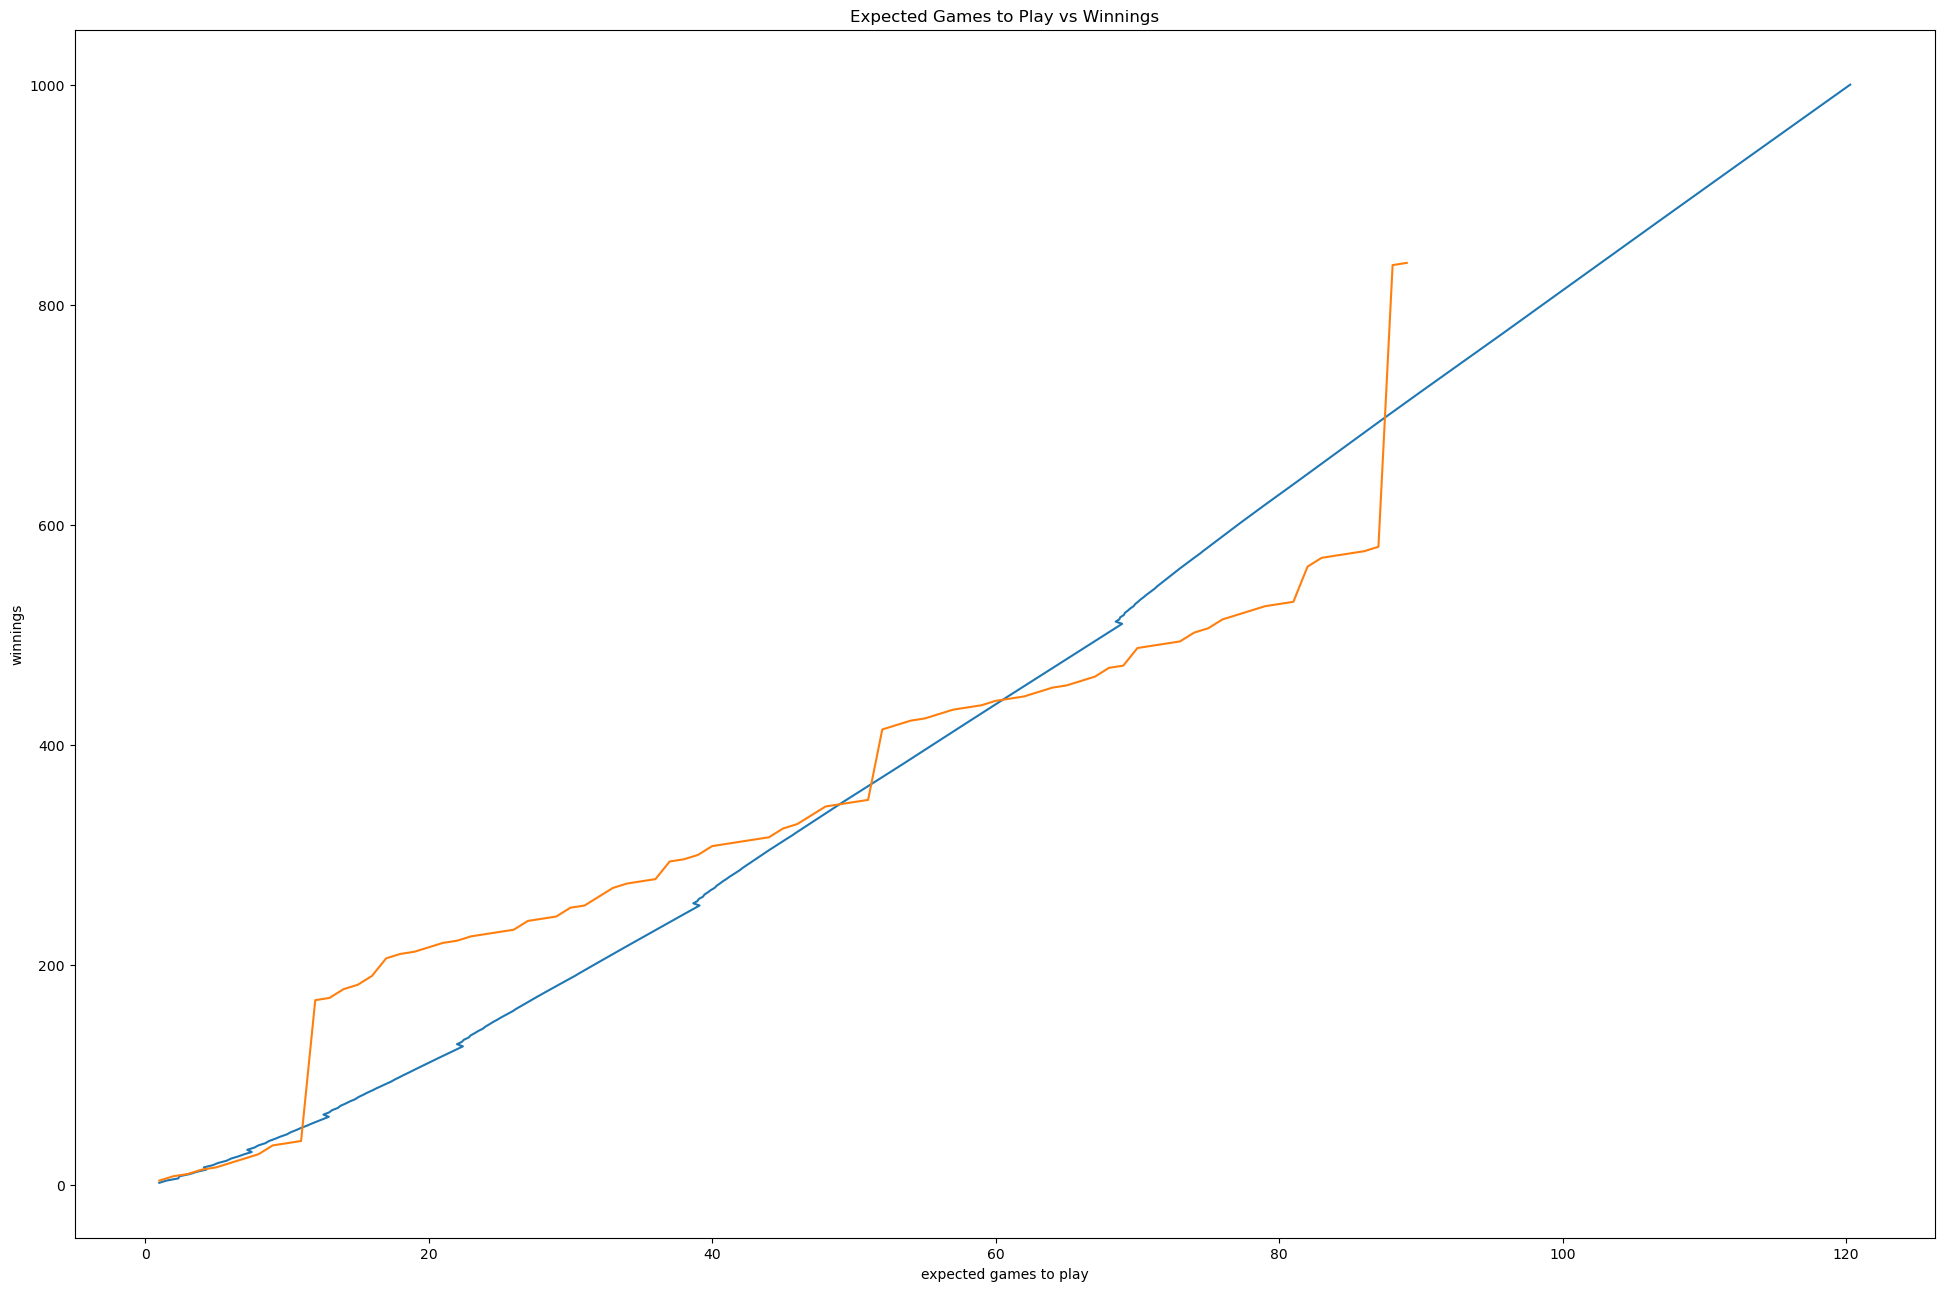

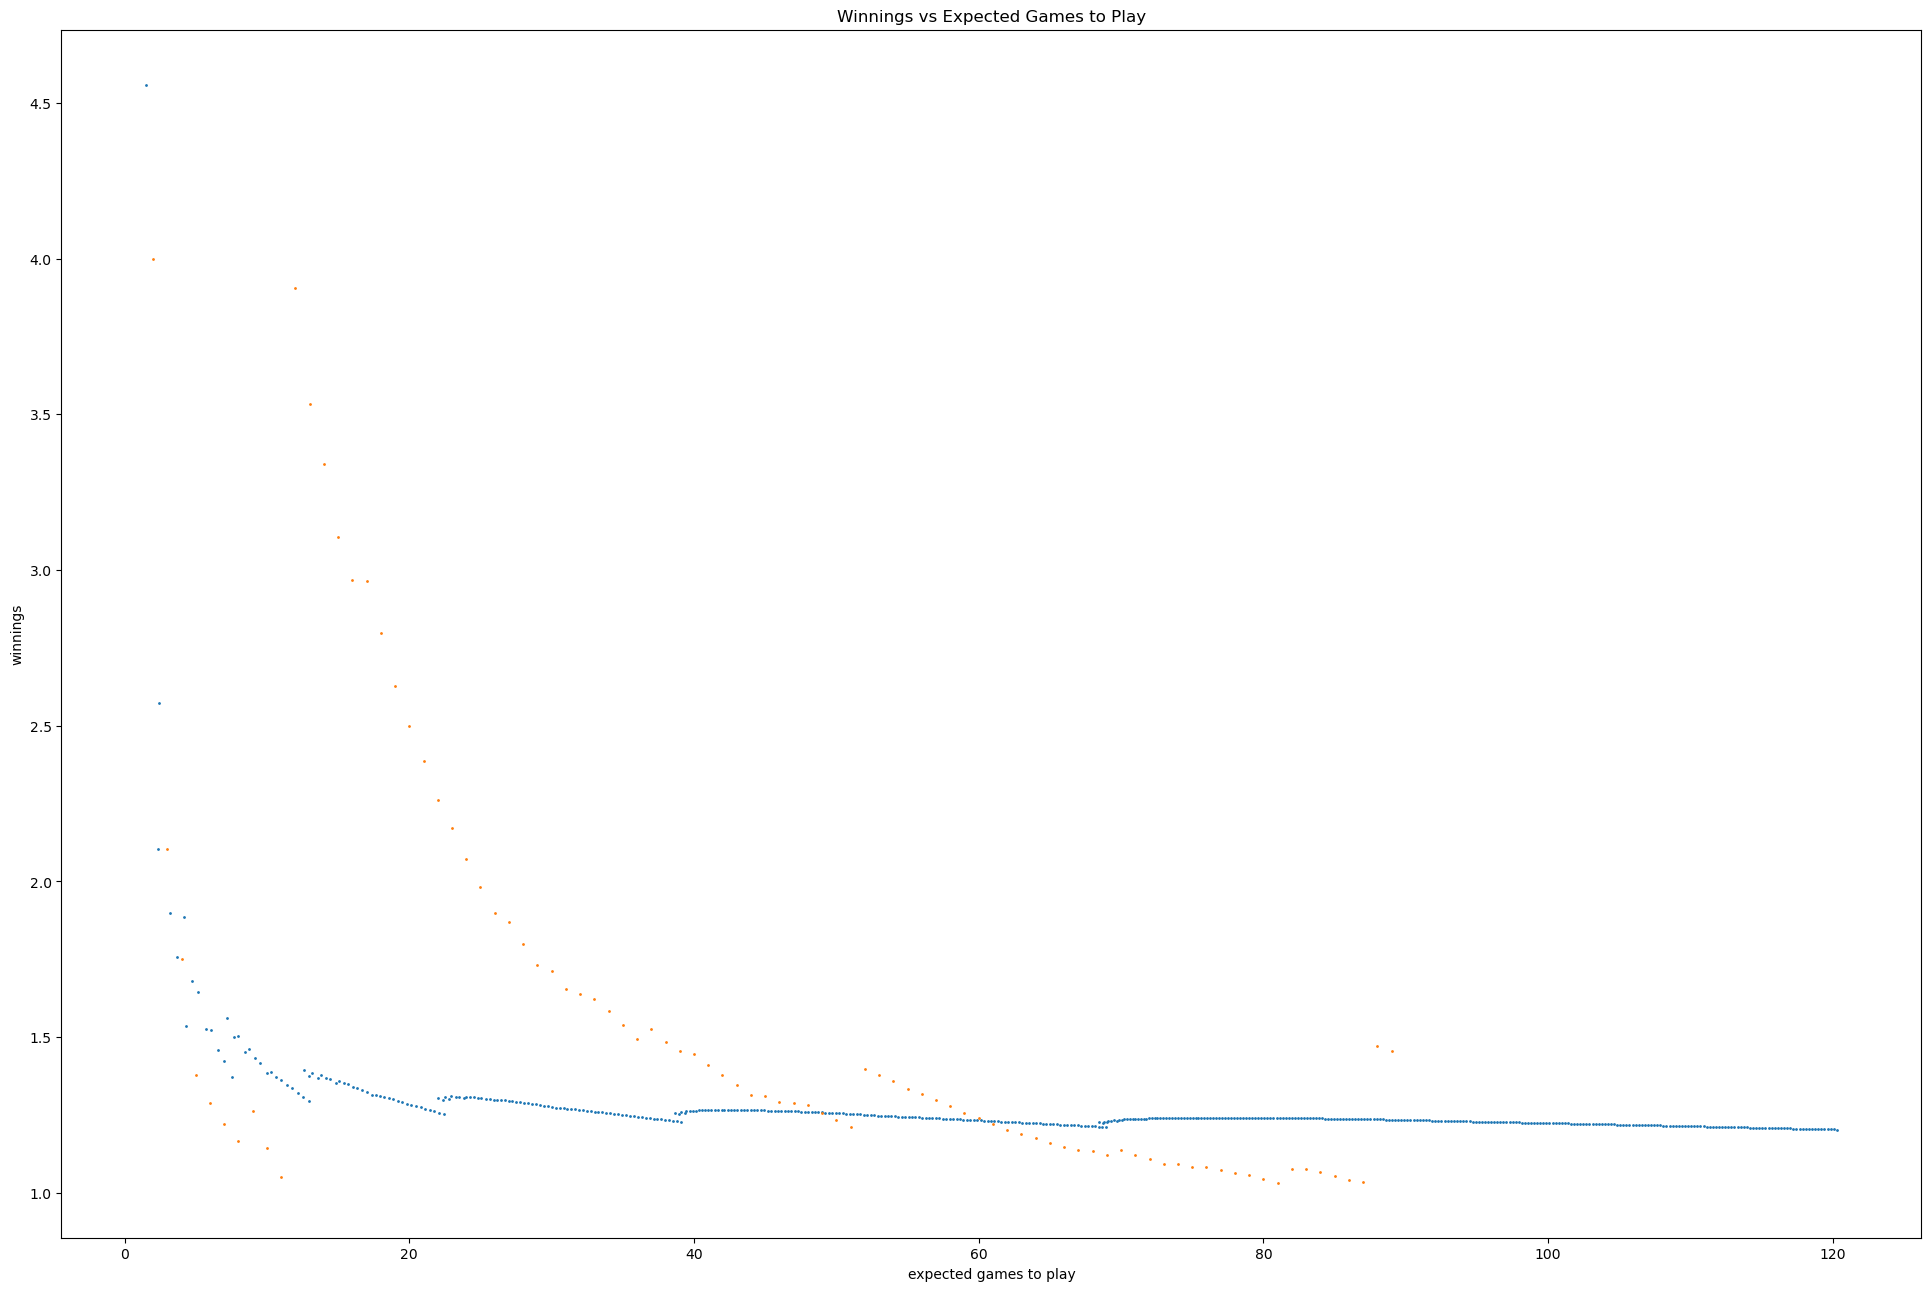

1.2031013464162708


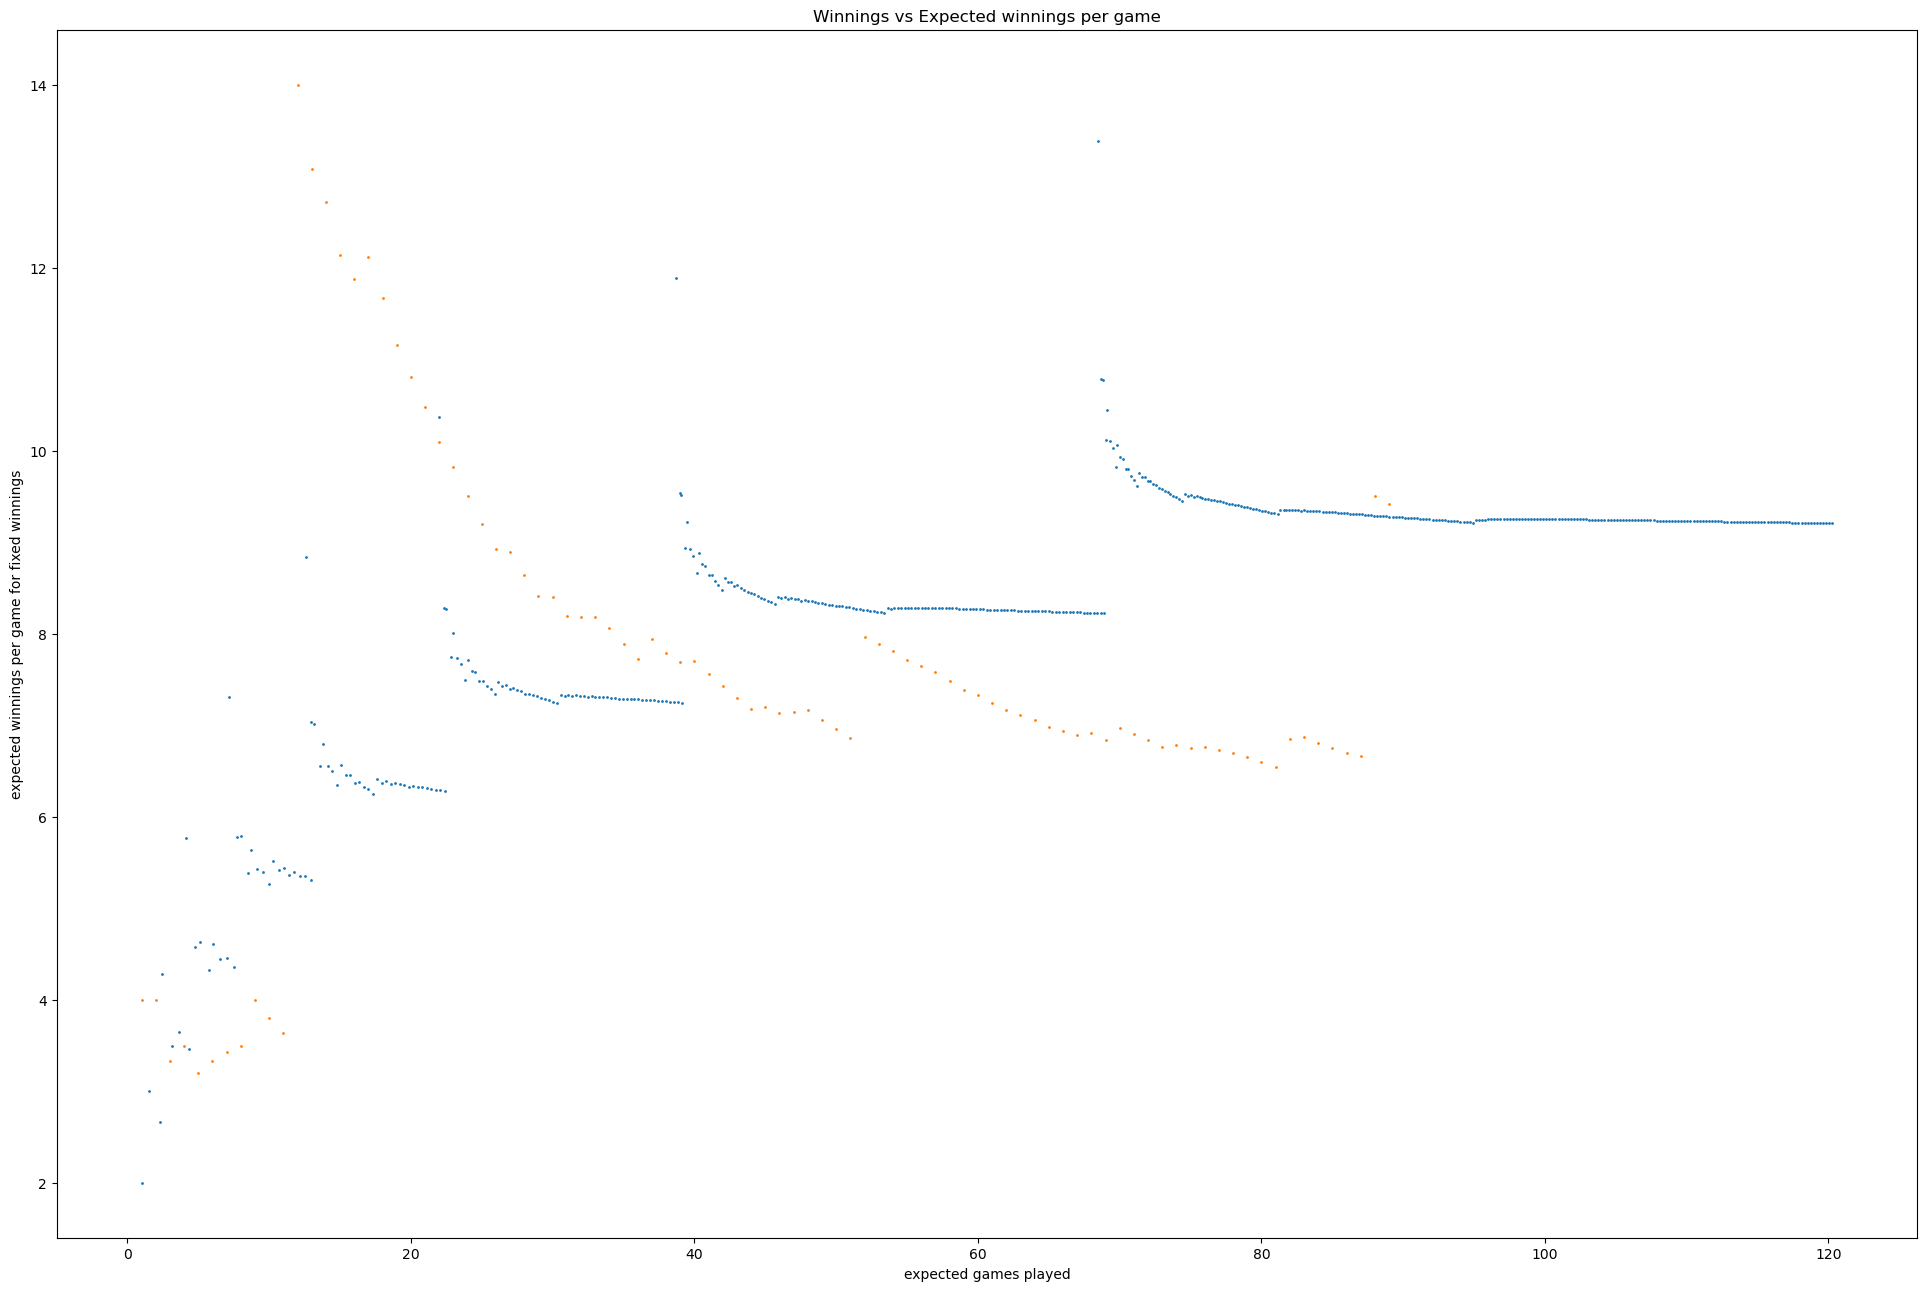

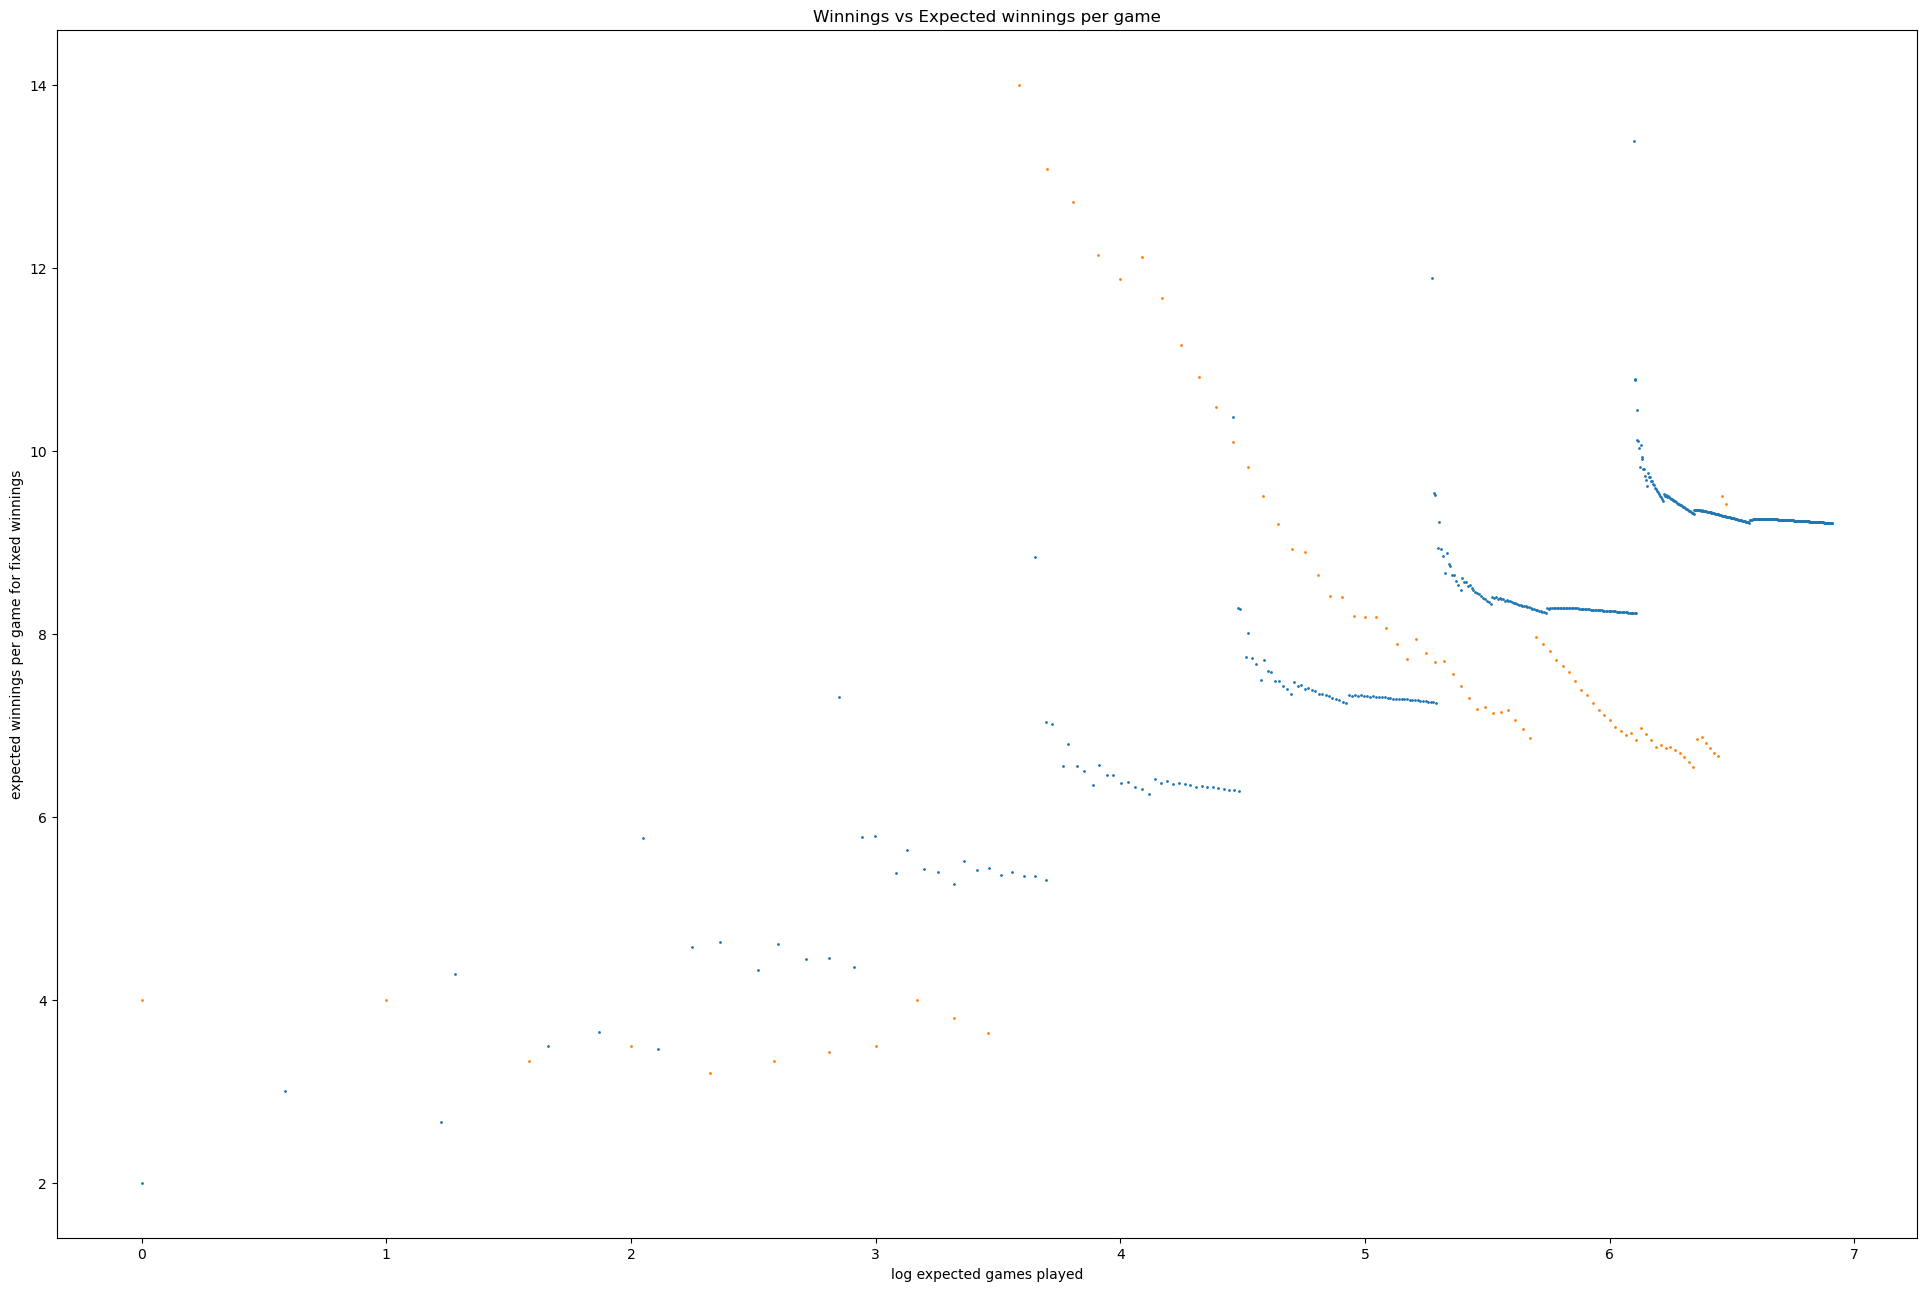

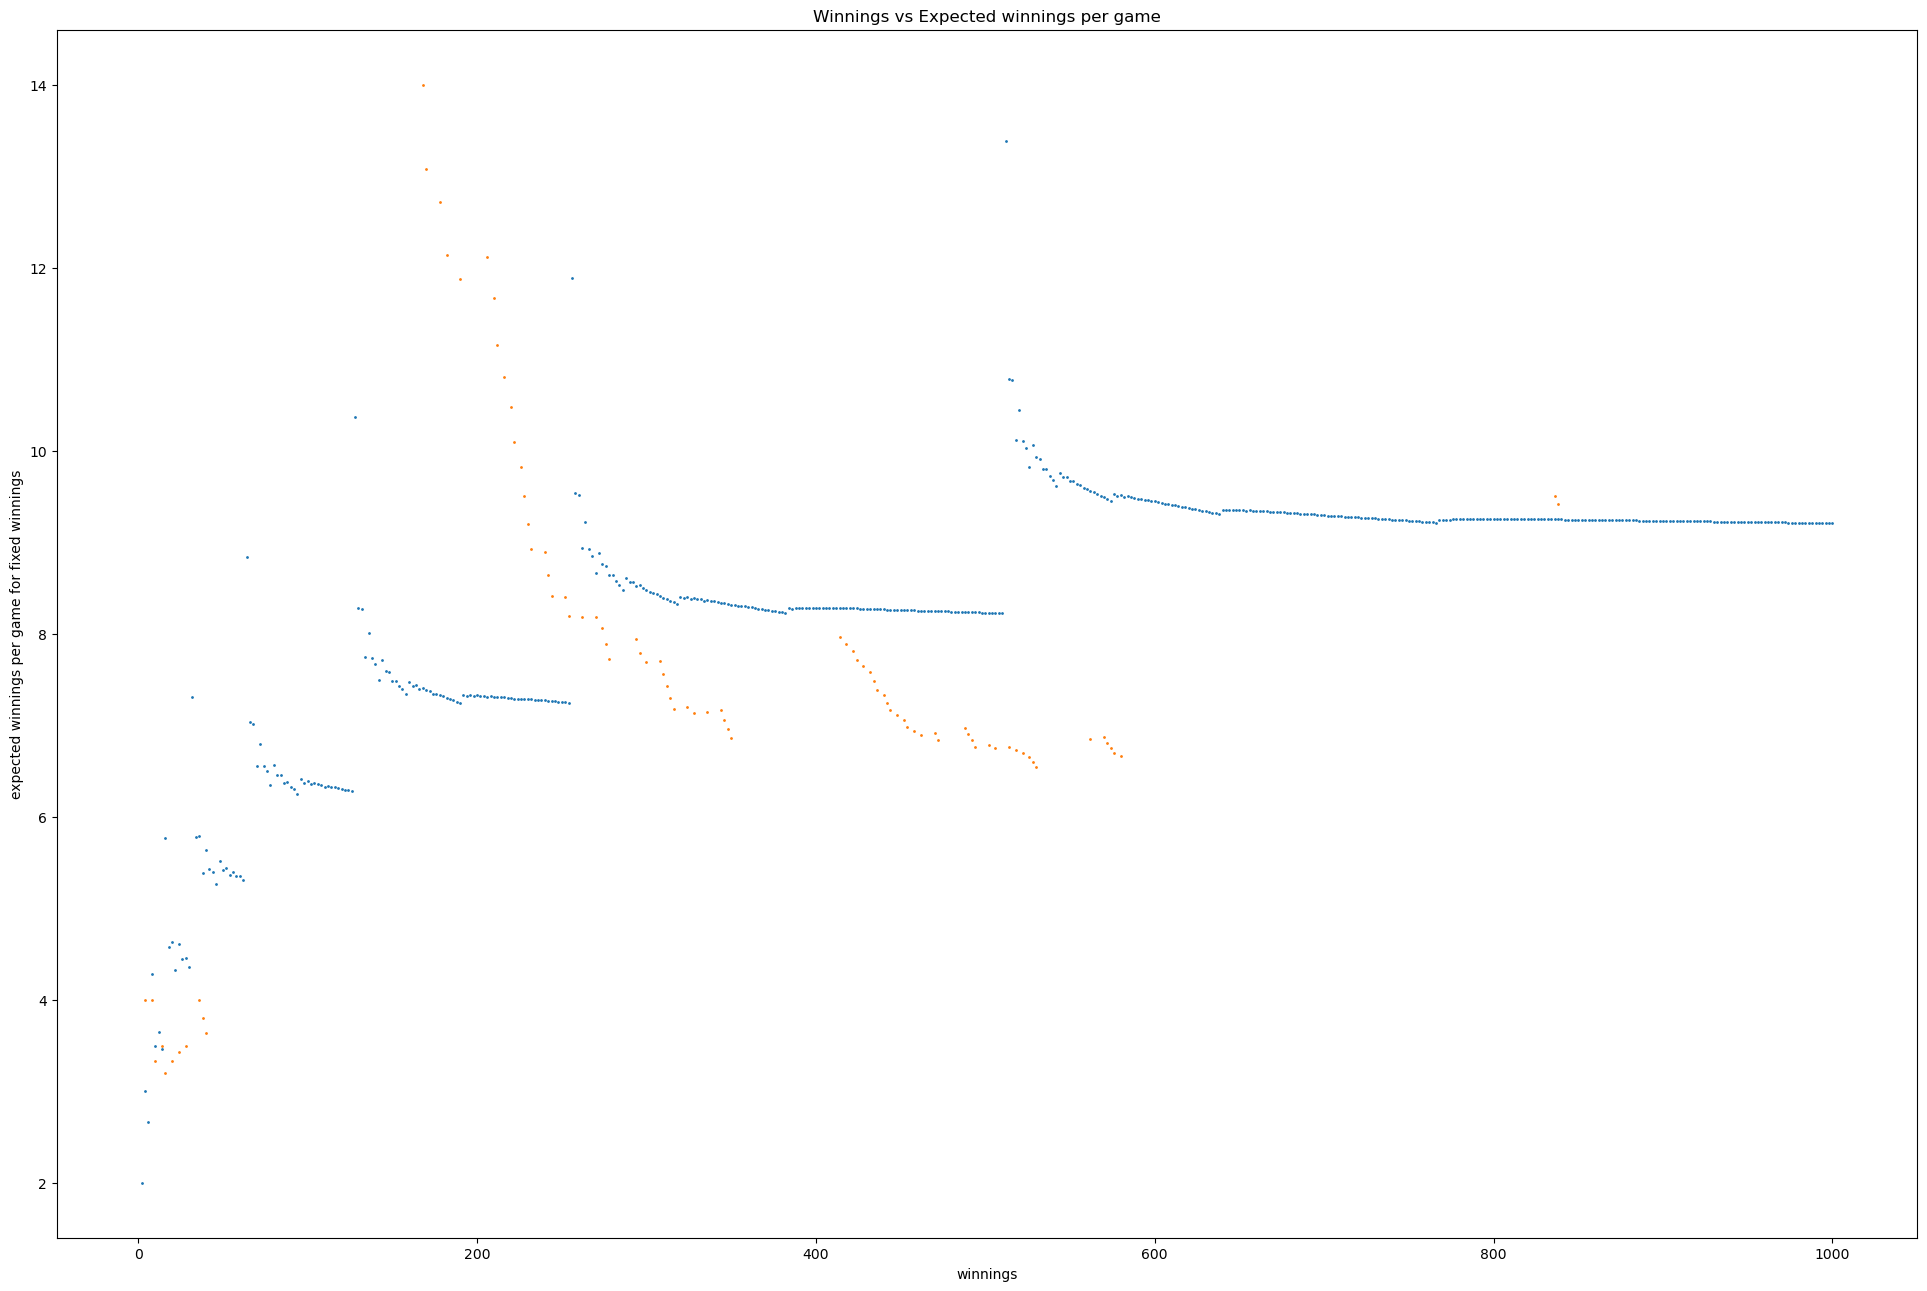

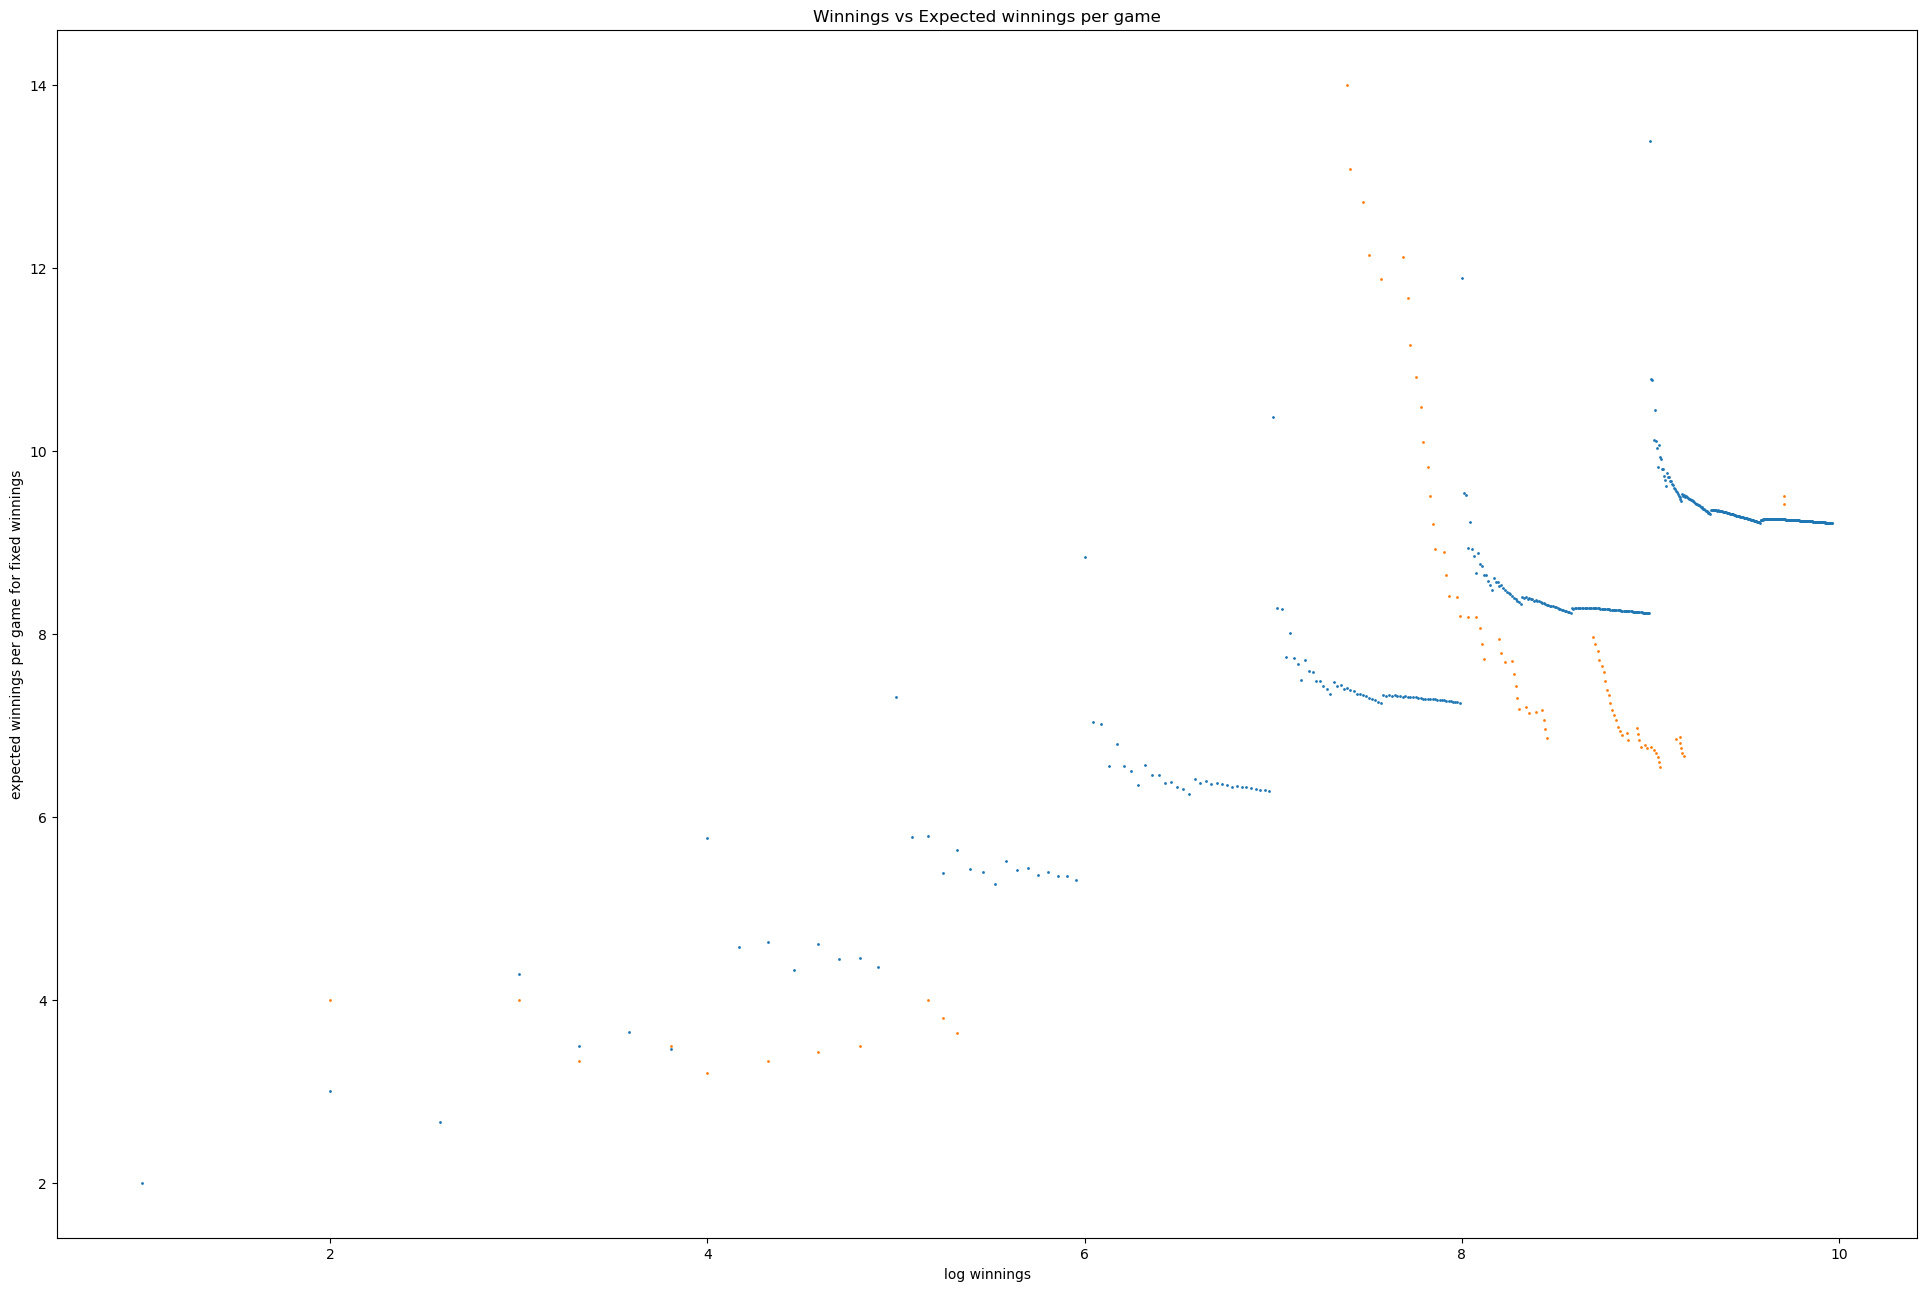

In [42]:
winnings = np.arange(2, len(egames), 2)
select = cumsum <= np.max(winnings)
emp_games = np.arange(1, TRIALS + 1)[select]
emp_mean = cummean[select]
emp_sum = cumsum[select]
dot_size = 1.0
def fig_gen():
    plt.figure(figsize=(24,16), dpi= 100, facecolor='w', edgecolor='k')

fig_gen()

plt.plot(egames[2::2], winnings)
plt.plot(emp_games, cumsum[select])
plt.ylabel("winnings")
plt.xlabel("expected games to play")
plt.title("Expected Games to Play vs Winnings")
plt.show()

fig_gen()

plt.scatter(egames[2::2], winnings / (egames[2::2] * (np.log2(egames[2::2]))), s=dot_size)
plt.scatter(emp_games, cumsum[select] / (emp_games * np.log2(emp_games)), s=dot_size)
plt.xlabel("expected games to play")
plt.ylabel("winnings")
plt.title("Winnings vs Expected Games to Play")
plt.show()

print((winnings / (egames[2::2] * np.log2(egames[2::2])))[-1])

fig_gen()

plt.scatter(egames[2::2], egain[2::2], s=dot_size)
plt.scatter(emp_games, emp_mean, s=dot_size)
plt.xlabel("expected games played")
plt.ylabel("expected winnings per game for fixed winnings")
plt.title("Winnings vs Expected winnings per game")
plt.show()

fig_gen()

plt.scatter(np.log2(egames[2::2]), egain[2::2], s=dot_size)
plt.scatter(np.log2(emp_games), emp_mean, s=dot_size)
plt.xlabel("log expected games played")
plt.ylabel("expected winnings per game for fixed winnings")
plt.title("Winnings vs Expected winnings per game")
plt.show()

fig_gen()

plt.scatter(winnings, egain[2::2], s=dot_size)
plt.scatter(emp_sum, emp_mean, s=dot_size)
plt.xlabel("winnings")
plt.ylabel("expected winnings per game for fixed winnings")
plt.title("Winnings vs Expected winnings per game")
plt.show()

fig_gen()

plt.scatter(np.log2(winnings), egain[2::2], s=dot_size)
plt.scatter(np.log2(emp_sum), emp_mean, s=dot_size)
plt.xlabel("log winnings")
plt.ylabel("expected winnings per game for fixed winnings")
plt.title("Winnings vs Expected winnings per game")
plt.show()